In [1]:

import os
import sys
import subprocess
# sys.path.insert(1, f"{subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')}/logistics/tools")
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools
import numpy as np
import openmc
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
# from tools import image_to_thesis
# image_to_thesis.pull_from_thesis()


100%|██████████| 1000/1000 [04:53<00:00,  3.41it/s]


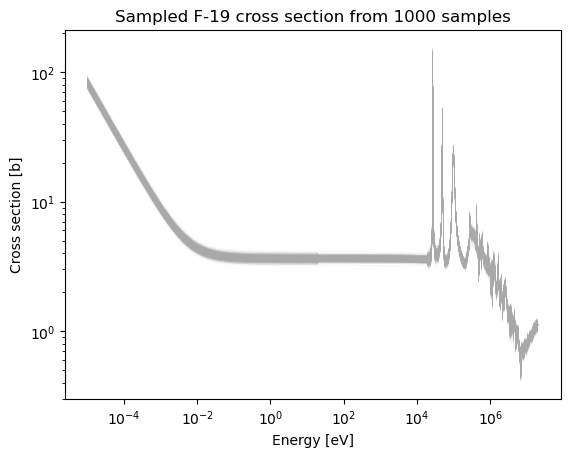

In [7]:
VERSION = "v1"

if VERSION == "v1":
    sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v1/hdf5/F19"
elif VERSION == "v2":
    sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v2"

fig = plt.figure()
ax = fig.gca()

TEMPERATURE = 900 # K

x_logspace = np.logspace(np.log10(1e-5), np.log10(2e7), 1000)

df = pd.DataFrame(columns=["energy", "xs"])

N_ITERATIONS = 1000
for i in tqdm(range(N_ITERATIONS)):
    h5_filename = f"{sampled_h5_files_path}/F19-{i+1}.h5"

    h5file = h5py.File(h5_filename, 'r')
    energy_group = h5file[f'F19/energy/{TEMPERATURE}K']
    reactions_group = h5file[f'F19/reactions']
    # for name, obj in sorted(list(main_group.items()))[:10]:
    #     if 'reaction_' in name:
    #         print('{}, {}'.format(name, obj.attrs['label'].decode()))

    n_elastic_xs_group = reactions_group[f'reaction_002/{TEMPERATURE}K/xs']
    # print(list(n_elastic_group.values()))

    # Extract the cross section and energy data
    energy = energy_group[:]
    xs = n_elastic_xs_group[:]

    # Interpolate the cross section to the desired energy grid
    xs = np.interp(x_logspace, energy, xs)
    energy = x_logspace

    df = pd.concat([df, pd.DataFrame({"energy": energy, "xs": xs})], ignore_index=True)

    # F19_reconstructed = openmc.data.IncidentNeutron.from_hdf5(h5_filename)

    # Plot the sampled cross section
    # ax.loglog(energy, xs, label="Sampled")
    ax.loglog(energy, xs, label="Sampled", color="darkgrey", linewidth=0.02)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Cross section [b]")
ax.set_title(f"Sampled F-19 cross section from {N_ITERATIONS} samples")

plt.savefig(f"sampled_cross_section_plot_{VERSION}.png", dpi=300)
    

In [8]:
print(len(df))
df.head()

1000000


,energy,xs
0,0.000010,77.351950
1,0.000010,76.266026
2,0.000011,75.194624
3,0.000011,74.137740
4,0.000011,73.095243


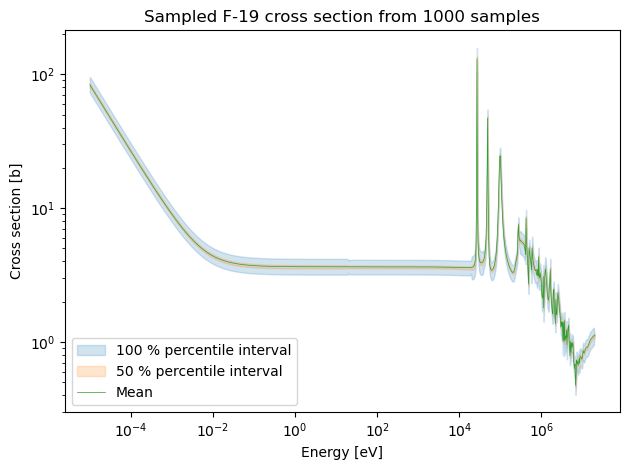

In [9]:
plt.figure()
ax = plt.gca()

sns.lineplot(data=df, x="energy", y="xs", errorbar=('pi', 100), linewidth=0, label='_nolegend_')
sns.lineplot(data=df, x="energy", y="xs", errorbar=('pi', 50), linewidth=0, label="_nolegend_")
sns.lineplot(data=df, x="energy", y="xs", errorbar=None, linewidth=0.5, label="")
plt.xscale("log")
plt.yscale("log")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Cross section [b]")
ax.set_title(f"Sampled F-19 cross section from {N_ITERATIONS} samples")
# plt.legend(['Mean', '50 % percentile interval', '90 % percentile interval', '100 % percentile interval'])
plt.legend(['100 % percentile interval', '50 % percentile interval', 'Mean'])
plt.tight_layout()

plt.savefig(f"errorbands_sampled_cross_section_plot_{VERSION}.pdf")